# EDA/Graphs
### Author: Adam Johnson
### UH ID: 2031383

In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

In [10]:
data = []
datasets = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]


for dataset in datasets:
    with open(Path("datasets") / dataset, "r") as f:
        for line in f:
            data.append(json.loads(line))

In [11]:
df = pd.DataFrame(data)

Author graph - Number of nodes: 300
Author graph - Number of edges: 27144
Top 15 authors by total citations:
 1. Anil K. Jain — 121850 citations
 2. David E. Goldberg — 113375 citations
 3. Hari Balakrishnan — 109682 citations
 4. Scott Shenker — 96827 citations
 5. Jiawei Han — 95502 citations
 6. Philip S. Yu — 88340 citations
 7. Geoffrey E. Hinton — 83801 citations
 8. Rakesh Agrawal — 83186 citations
 9. Michael I. Jordan — 82241 citations
10. Deborah Estrin — 81389 citations
11. Thomas S. Huang — 79542 citations
12. Andrew Zisserman — 78278 citations
13. David G. Lowe — 77912 citations
14. David E. Culler — 77068 citations
15. Jitendra Malik — 75885 citations


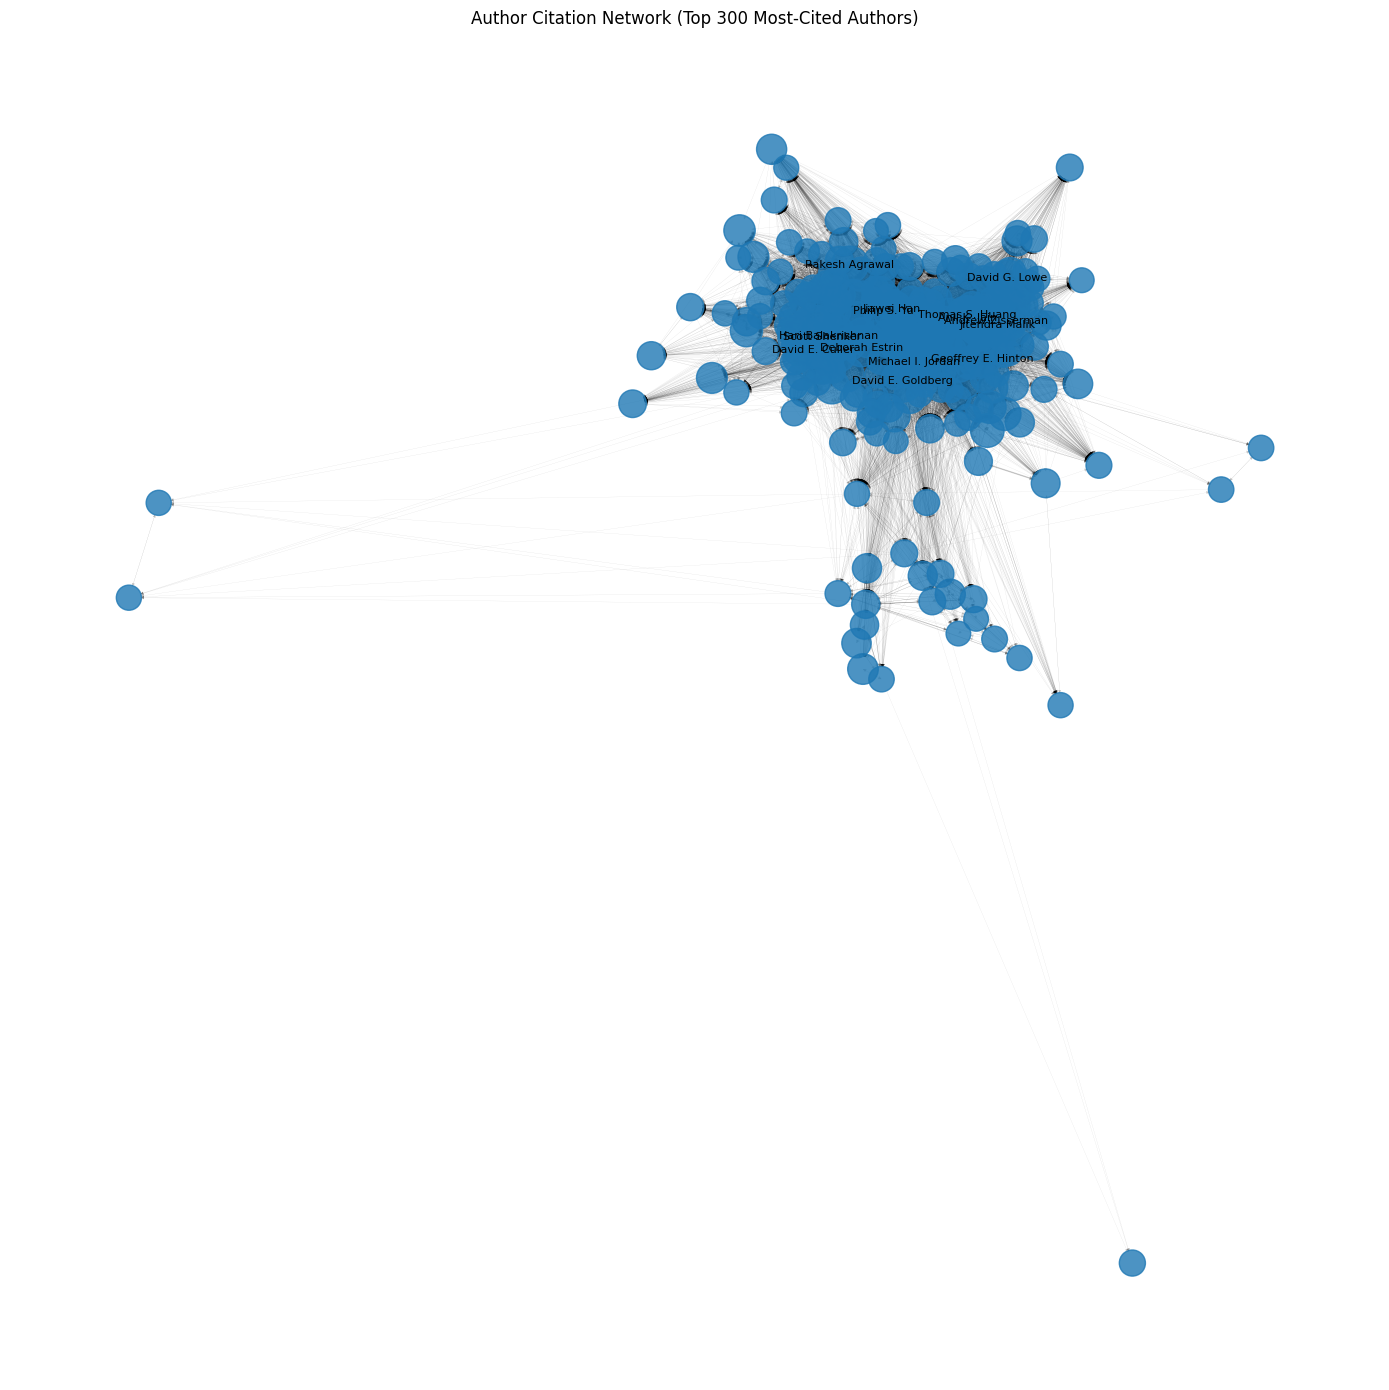

In [17]:
df_auth = df[["id", "authors", "references", "n_citation"]].copy()

paper_id_to_authors = {}
paper_id_to_n_citation = {}

for _, row in df_auth.iterrows():
    pid = row.get("id")
    if not isinstance(pid, str):
        continue

    authors = row.get("authors")
    if not isinstance(authors, list):
        authors = []
    paper_id_to_authors[pid] = authors

    n_cit = row.get("n_citation", 0)
    if pd.isna(n_cit):
        n_cit = 0
    paper_id_to_n_citation[pid] = int(n_cit)

author_citations_auth = Counter()

for pid, authors in paper_id_to_authors.items():
    n_cit = paper_id_to_n_citation.get(pid, 0)
    for a in authors:
        if a:
            author_citations_auth[a] += n_cit

TOP_N_AUTHORS = 300
top_authors_set = {a for a, _ in author_citations_auth.most_common(TOP_N_AUTHORS)}

author_edge_weights = Counter()

for _, row in df_auth.iterrows():
    source_authors = row.get("authors")
    if not isinstance(source_authors, list):
        continue

    source_authors = [a for a in source_authors if a in top_authors_set]
    if not source_authors:
        continue

    refs = row.get("references")
    if not isinstance(refs, list):
        continue

    for ref_id in refs:
        target_authors = paper_id_to_authors.get(ref_id)
        if not target_authors:
            continue

        target_authors = [b for b in target_authors if b in top_authors_set]
        if not target_authors:
            continue

        for a in source_authors:
            for b in target_authors:
                if a == b:
                    continue
                author_edge_weights[(a, b)] += 1

G_auth = nx.DiGraph()

for author in top_authors_set:
    G_auth.add_node(author, citations=author_citations_auth[author])

for (a, b), w in author_edge_weights.items():
    G_auth.add_edge(a, b, weight=w)

print(f"Author graph - Number of nodes: {G_auth.number_of_nodes()}")
print(f"Author graph - Number of edges: {G_auth.number_of_edges()}")

pos_auth = nx.spring_layout(G_auth, k=0.3, iterations=50, seed=42)

citations_list_auth = [G_auth.nodes[n]["citations"] for n in G_auth.nodes()]
max_cit_auth = max(citations_list_auth) if citations_list_auth else 1
node_sizes_auth = [
    100 + 900 * (c / max_cit_auth)
    for c in citations_list_auth
]

if G_auth.number_of_edges() > 0:
    edge_weight_list_auth = [d["weight"] for _, _, d in G_auth.edges(data=True)]
    max_w_auth = max(edge_weight_list_auth)
    edge_widths_auth = [0.1 + 3.0 * (w / max_w_auth) for w in edge_weight_list_auth]
else:
    edge_widths_auth = []

plt.figure(figsize=(14, 14))

nx.draw_networkx_nodes(
    G_auth,
    pos_auth,
    node_size=node_sizes_auth,
    alpha=0.8,
)

nx.draw_networkx_edges(
    G_auth,
    pos_auth,
    width=edge_widths_auth,
    alpha=0.2,
    arrowsize=5,
)

TOP_LABELED_AUTHORS = 15
top_authors = author_citations_auth.most_common(TOP_LABELED_AUTHORS)

print("Top 15 authors by total citations:")
for rank, (author, cit) in enumerate(top_authors, start=1):
    print(f"{rank:2d}. {author} — {cit} citations")

label_authors_auth = {a for a, _ in top_authors}
labels_auth = {n: n for n in G_auth.nodes() if n in label_authors_auth}

nx.draw_networkx_labels(
    G_auth,
    pos_auth,
    labels=labels_auth,
    font_size=8,
)

plt.title(f"Author Citation Network (Top {TOP_N_AUTHORS} Most-Cited Authors)")
plt.axis("off")
plt.tight_layout()
plt.show()


Subgraph: 1000 nodes, 1862 edges

Top 30 papers by citation count:
 1. Genetic Algorithms in Search, Optimization and Machine Learning  —  73362 citations  (id=6a6b9aa6-683f-4c7c-b06e-9c3018d10fd3)
 2. Distinctive Image Features from Scale-Invariant Keypoints  —  42508 citations  (id=b944f77f-113b-4a02-ae5e-d4a124b8fd5b)
 3. Bowling alone: the collapse and revival of American community  —  34288 citations  (id=ac744614-9003-4ccb-93bf-2fe5b1ef4166)
 4. LIBSVM: A library for support vector machines  —  33016 citations  (id=c1b6b493-01ef-420f-be44-7bacfe34e846)
 5. Reinforcement Learning: An Introduction  —  29285 citations  (id=e0f3a738-4ab2-40d1-ba44-506d81c1d230)
 6. Random Forests  —  28679 citations  (id=f6bd8b64-684d-429a-aab5-8ff3a2c23cd6)
 7. Perceived usefulness, perceived ease of use, and user acceptance of information technology  —  27068 citations  (id=9d912297-e52f-4ab6-add4-633e0f263933)
 8. Ad-hoc on-demand distance vector routing  —  26357 citations  (id=0d4d0363-07b5-43b6

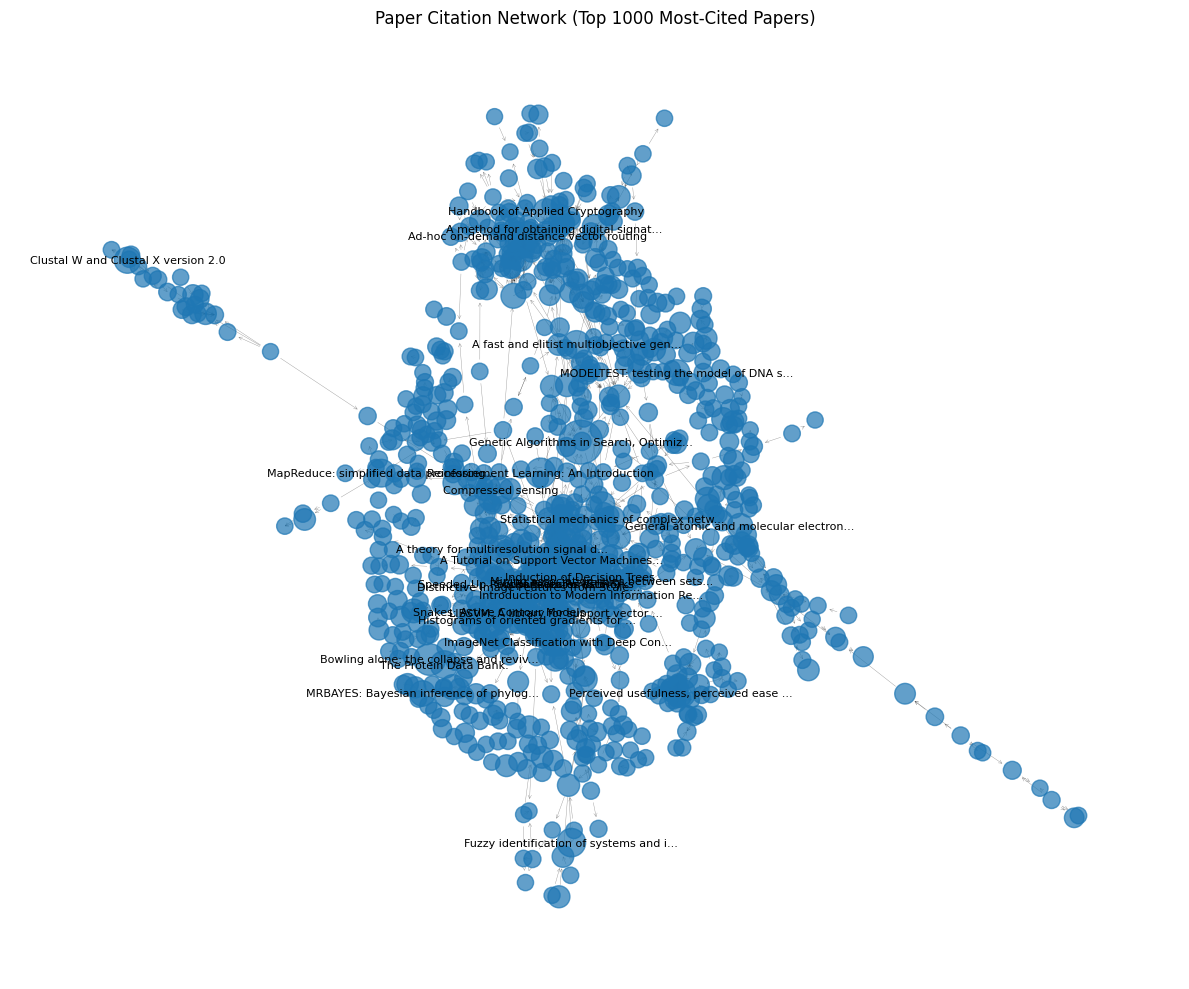

In [18]:
TOP_N = 1000

df["n_citation"] = pd.to_numeric(df["n_citation"], errors="coerce").fillna(0).astype(int)

df_top = df.nlargest(TOP_N, "n_citation").copy()
df_top.reset_index(drop=True, inplace=True)

id_set = set(df_top["id"].values)

G = nx.DiGraph()

for _, row in df_top.iterrows():
    G.add_node(
        row["id"],
        title=row.get("title", ""),
        n_citation=row.get("n_citation", 0)
    )

edge_list = []
for _, row in df_top.iterrows():
    src_id = row["id"]
    refs = row.get("references", [])

    if not isinstance(refs, list):
        continue

    for ref_id in refs:
        if ref_id in id_set:
            edge_list.append((src_id, ref_id))

G.add_edges_from(edge_list)

print(f"Subgraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

node_ids = list(G.nodes())
cit_counts = np.array([G.nodes[n].get("n_citation", 0) for n in node_ids], dtype=float)

if cit_counts.max() > 0:
    sizes = 100 + 900 * (cit_counts / cit_counts.max())
else:
    sizes = np.full_like(cit_counts, 300)

plt.figure(figsize=(12, 10))

nx.draw_networkx_nodes(
    G,
    pos,
    node_size=sizes,
    node_color="tab:blue",
    alpha=0.7
)

nx.draw_networkx_edges(
    G,
    pos,
    arrows=True,
    arrowstyle="->",
    arrowsize=6,
    width=0.3,
    alpha=0.4
)

TOP_LABELS = 30
top_nodes = sorted(
    node_ids,
    key=lambda n: G.nodes[n].get("n_citation", 0),
    reverse=True
)[:TOP_LABELS]

print(f"\nTop {TOP_LABELS} papers by citation count:")
for rank, n in enumerate(top_nodes, start=1):
    title = G.nodes[n].get("title", "")
    n_cit = G.nodes[n].get("n_citation", 0)
    print(f"{rank:2d}. {title}  —  {n_cit} citations  (id={n})")

labels = {}
for n in top_nodes:
    title = G.nodes[n].get("title", "")
    if len(title) > 40:
        title = title[:37] + "..."
    labels[n] = title

nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    font_size=8
)

plt.title(f"Paper Citation Network (Top {TOP_N} Most-Cited Papers)")
plt.axis("off")
plt.tight_layout()
plt.show()
